# Volatility surface calibration
#### Dmitry Bazanov - MIPT
#### Roland Grinis - MIPT & GrinisRIT
#### Ivan Novikov - MIPT

In [1]:
import torch
from torch.utils.cpp_extension import load
import numpy as np
import numba as nb
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline
torch.manual_seed(987654);

## 1. Implied Volatility

#### 1.1 CDF Approximation
Zelen & Severo approximation for the standard normal CDF $\text{N}(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is given by: 
$$
\text{N}(x) = 1 - \text{N}'(x) \sum_{i=1}^{5} b_i t^i + \epsilon (x)
$$
where $t = (1 + b_0 x)^{-1}$, the error is bounded by $|\epsilon (x)| < 7.5 \cdot 10^{-8}$ and the coefficients $b_i$ are fixed (see implementation).

$$
b_0 = 0.2316419 
$$
$$
b_1 = 0.319381530 
$$
$$
b_2 = -0.356563782 
$$
$$
b_3 = 1.781477937 
$$
$$
b_4 = -1.821255978 
$$
$$
b_5 = 1.330274429
$$

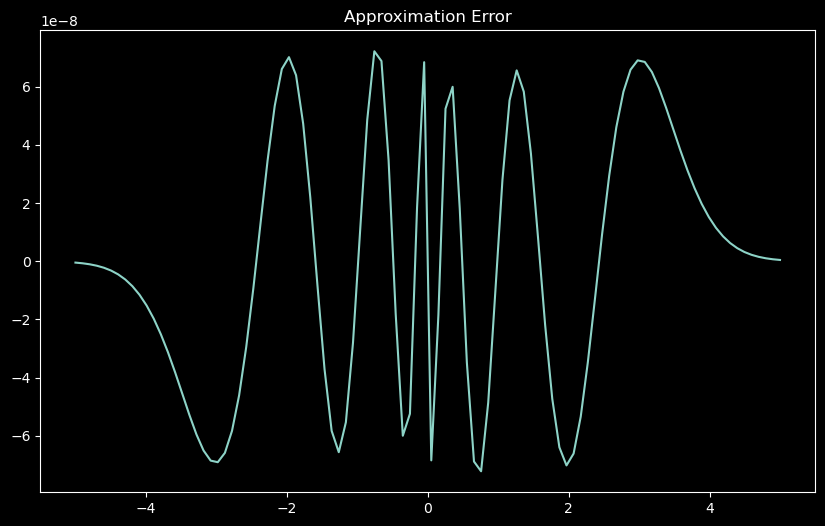

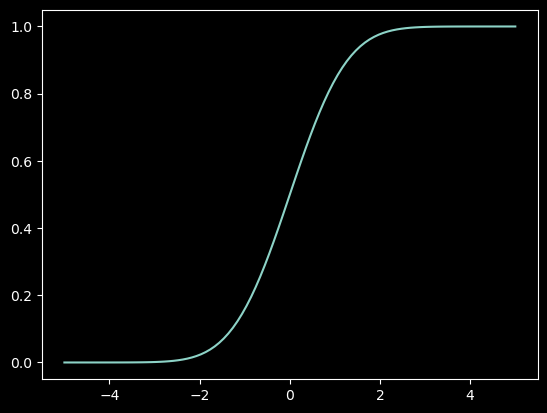

In [2]:
@nb.njit()
def normal_cdf(x):
    t = 1 / (1 + 0.2316419*abs(x))
    summ = 0.319381530*t - 0.356563782*t**2 + 1.781477937*t**3 - 1.821255978*t**4 + 1.330274429*t**5
    if x >= 0:
        return 1 - summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)
    else:
        return summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)

x = np.linspace(-5, 5, 100)
N0 = norm.cdf(x)
N1 = tuple(map(normal_cdf, x))

plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.plot(x, N0 - np.array(N1))
plt.title('Approximation Error')
plt.show()

plt.plot(x, N1)

#### 1.2 Newton-Raphson for Implied Volatility

Implied volatility is defined as the volatility level $\sigma$ one needs to plug into the Black-Scholes formula $\mathcal{BS}$ to obtain the market present value $PV^{m k t}$ of the option:

$$
g\left(\sigma_{\text {imp }}\right)=PV^{m k t}(K, T)-\mathcal{BS}\left(t_0=0, S_0 ; K, T, \sigma_{\text {imp }}, r\right)=0 
$$

Given an initial guess for the implied volatility, i.e. $\sigma_{\text {imp }}^{(0)}$, we can find the next approximations, $\sigma_{\text {imp }}^{(k)}, k=1,2, \ldots$, by means of the Newton-Raphson iterative algorythm, as follows

$$
\sigma_{\text {imp }}^{(k+1)}=\sigma_{\text {imp }}^{(k)}-\frac{g\left(\sigma_{\text {imp }}^{(k)}\right)}{g^{\prime}\left(\sigma_{\text {imp }}^{(k)}\right)}, \text { for } k \geq 0 .
$$
where actually the derivative is negative vega:
$$
g^{\prime}\left(\sigma_{\text {imp }}^{(k)} \right) = - \mathcal{V}(\sigma_{\text {imp}}^{(k)})
$$
This algorithm has second order convergence.


#### 1.3 Combined Algorythm (Newton-Raphson + Bisection):

For deep OTM options vega is close to zero - this might lead to instabilities for the Newton-Raphson method. To deal with this, we augment the later with the bisection method (mainly used for sanity checks as it's first order).  
Determine initial interval $\left[\sigma_{\text {imp }}^l, \sigma_{\text {imp }}^r\right]$
If $g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^r\right)>0$ stop (there is no zero in the interval)

Else: 
$$
\delta=-\frac{g\left(\sigma_{imp}^{(k)}\right)} {g^{\prime}\left(\sigma_{imp}^{(k)}\right)}
$$
$$
\sigma_{imp}^{(0)} = \frac{1}{2} (\sigma_{imp}^l + \sigma_{imp}^r)
$$
Let $\epsilon = g\left(\sigma_{imp}^0\right)$, While $|\epsilon|>$ tolerance:

$$
\sigma_{imp}^{(k+1)}=\sigma_{imp}^{(k)}+ \delta 
$$
$$
\text { if } \sigma_{imp}^{(k+1)} \notin \left[\sigma_{imp}^l, \sigma_{imp}^r\right]
$$
$$
\quad \text { if } g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^{(k+1)}\right)>0 
\text { then } \sigma_{imp}^l=\sigma_{imp}^{(k)} 
$$
$$
\quad \text { if } g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^{(k+1)}\right)<0 
\text { then } \sigma_{imp}^r=\sigma_{imp}^{(k)} 
$$
$$
\quad \sigma_{imp}^{(k+1)}=\left(\sigma_{imp}^l+\sigma_{imp}^r\right) / 2 
$$
$$
\epsilon = g\left(\sigma_{imp}^{(k+1)}\right)
$$
$$
\delta=- \frac{\epsilon}{ g^{\prime}\left(\sigma_{imp}^{(k+1)}\right) }
$$

In [50]:
@nb.njit()
def black_scholes(sigma, S0, K, dt, r, call=True):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d2 = d1 - sigma * np.sqrt(dt)
    p = 1 if call else -1
    return p*S0*normal_cdf(p*d1) - p*K*np.exp(-r*dt)*normal_cdf(p*d2)

In [51]:
@nb.njit()
def black_scholes_vega(sigma, S0, K, dt, r):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    return S0 * np.sqrt(dt) * np.exp(-d1**2 / 2) / np.sqrt(2*np.pi)

In [52]:
@nb.njit()
def black_scholes_delta(sigma, S0, K, dt, r, call=True):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    p = 1 if call else -1
    return p*normal_cdf(p*d1)

In [53]:
@nb.njit()
def g(V_mkt, sigma, dt, S0, K, r, call=True):
    return V_mkt - black_scholes(sigma, S0, K, dt, r, call)


@nb.njit()
def g_prime(sigma, dt, S0, K, r):
    return -black_scholes_vega(sigma, S0, K, dt, r)

@nb.njit()
def implied_vol(V_mkt, S0, K, dt, r, call=True, tol=10**-4, sigma_l=10**-8, sigma_r=1):
    if g(V_mkt, sigma_l, dt, S0, K, r, call)*g(V_mkt, sigma_r, dt, S0, K, r, call) > 0:
        print('no zero at the initial interval')
    else:
        sigma = (sigma_l + sigma_r) / 2
        shift = - g(V_mkt, sigma, dt, S0, K, r, call) / g_prime(sigma, dt, S0, K, r)
        
        epsilon = g(V_mkt, sigma, dt, S0, K, r, call)

        while abs(epsilon) > tol:
            sigma = sigma + shift
            if sigma > sigma_r or sigma < sigma_l:
                if g(V_mkt, sigma_l, dt, S0, K, r, call)*g(V_mkt, sigma, dt, S0, K, r, call) > 0:
                    sigma_l = sigma
                else:
                    sigma_r = sigma

                sigma = (sigma_l + sigma_r) / 2
            epsilon = g(V_mkt, sigma, dt, S0, K, r, call)
            shift = - epsilon / g_prime(sigma, dt, S0, K, r)
        return sigma

In [55]:
implied_vol(V_mkt=
            black_scholes(sigma=0.3, S0=100, K=80, dt=0.8, r=0.01, call=False), 
                                     S0=100, K=80, dt=0.8, r=0.01, call=False,
                sigma_l=0.01, sigma_r=0.9)

0.3000000233632885

## 2. Levenberg-Marquardt algorithm

The Levenberg-Marquardt algorithm combines two numerical minimization algorithms: the gradient descent method and the
Gauss-Newton method. In the gradient descent method, the sum of the squared errors is reduced by updating the parameters in the steepest-descent direction. In the
Gauss-Newton method, the sum of the squared errors is reduced by assuming the least
squares function is locally quadratic in the parameters, and finding the minimum of
this quadratic. The Levenberg-Marquardt method acts more like a gradient-descent
method when the parameters are far from their optimal value, and acts more like the
Gauss-Newton method when the parameters are close to their optimal value.

["The Levenberg-Marquardt algorithm for
nonlinear least squares curve-fitting problems" Henri P. Gavin 2022](https://people.duke.edu/~hpgavin/ExperimentalSystems/lm.pdf)

##### Levenberg-Marquardt

$$
\chi^2(\boldsymbol{\theta}) =(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}));
$$

$$ W_{ii} = \frac{1}{w_i^2}, \quad \sigma = [\sigma_i], \quad \hat{\sigma} = [\hat{\sigma_i}] $$

##### Gradient descent

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} \chi^2 & =-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}; \quad \boldsymbol{J} = \left[\frac{\partial \hat{\boldsymbol{y}}(\boldsymbol{p})}{\partial \boldsymbol{p}}\right]
\end{aligned}
$$

$$ \text{step: } h_g = \lambda \boldsymbol{J}^T \boldsymbol{W} (\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}); \quad \lambda > 0 \text{ - learning rate} $$

##### Gauss-Newton Method  $ \quad |h| << 1 $

$$\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}+\boldsymbol{h}) \approx \hat{\boldsymbol{\sigma}}(\boldsymbol{\theta})+\boldsymbol{J} \boldsymbol{h} \quad \rightarrow \quad \chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx \boldsymbol{\sigma}^{\top} \boldsymbol{W} \boldsymbol{\sigma}+\hat{\boldsymbol{\sigma}}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2 \boldsymbol{\sigma}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h}+\boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h} $$

$$
\rightarrow \frac{\partial}{\partial \boldsymbol{h}} \chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}+2 \boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}
$$

$$
\text{optimal step: } \left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right] \boldsymbol{h}_{\mathrm{gn}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg Equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \boldsymbol{I}\right] \boldsymbol{h}_{\mathrm{lm}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg-Marquardt equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right)\right] \boldsymbol{h}_{\mathrm{Im}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{y}-\hat{\boldsymbol{y}})
$$

##### Improvement metric

$$
\mu\left(\boldsymbol{h}_{\mathrm{lm}}\right)=\frac{\chi^2(\boldsymbol{\theta})-\chi^2\left(\boldsymbol{\theta}+\boldsymbol{h}_{\mathrm{lm}}\right)}{(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})-\left(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}-\boldsymbol{J} \boldsymbol{h}_{\mathrm{lm}}\right)^{\top} \boldsymbol{W}\left(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}-\boldsymbol{J} \boldsymbol{h}_{\mathrm{lm}}\right)}
$$

$$
\mu << 1 \quad \rightarrow \quad \text{Gradient descent mode} \quad (\boldsymbol{\lambda} \text{ - is increasing})
$$

$$
\mu >> 1 \quad \rightarrow \quad \text{Gauss-Newton mode } \quad (\boldsymbol{\lambda} \text{ - is decreasing})
$$

$$
\boldsymbol{\mu}_{\lambda}(\boldsymbol{h}_{\mathrm{lm}}) = \frac{\chi^2(\boldsymbol{\theta})-\chi^2\left(\boldsymbol{\theta}+\boldsymbol{h}_{\mathrm{lm}}\right)}{\boldsymbol{h}_{\mathrm{lm}}^{\top}\left(\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} J\right) \boldsymbol{h}_{\mathrm{lm}}+\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))\right)}
$$

##### Step procedure

$$ \boldsymbol{\lambda} = 10^{-2}  \quad \quad \boldsymbol{L} \downarrow = 9 \quad \quad \boldsymbol{L} \uparrow = 11 \quad \quad \boldsymbol{\epsilon} = 10^{-1} $$

$$ \text{solve the L-M equation with  } \boldsymbol{\lambda} \quad \rightarrow \quad \boldsymbol{h}_{\mathrm{lm}} $$

$$
\begin{aligned}
& \text{if } \quad \boldsymbol{N}_{\lambda} (\boldsymbol{h}_{\mathrm{lm}}) > \boldsymbol{\epsilon}: \\
& \quad \quad \boldsymbol{\theta} = \boldsymbol{\theta} + \boldsymbol{h}_{\mathrm{lm}} \\
& \quad \quad \boldsymbol{\lambda} = \max (\frac{\lambda}{L \uparrow}, 10^{-7}) \\
& \text{else: } \\
&  \quad \quad \boldsymbol{\lambda} = \min (\lambda L \uparrow , 10^{7})
\end{aligned}
$$

##### Convergence Criteria

- Gradient convergence: $\max \left|\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{y}-\hat{\boldsymbol{y}})\right|< 10^{-3}$;
- Parameters convergence: $\max \left|h_i / p_i\right|<10^{-3} ;$ or
- Convergence in $\chi^2:$ uses the value of the reduced $\chi^2, \chi_\nu^2=\chi^2 /(m-n+1)<10^{-1}$.  (where $n$ - sample size, $m$ - param. dimension)

##### Error analysis

$$ \chi_\nu^2 >> 1 \text{ - poor fit };  \quad \chi_\nu^2 \approx 1 \text{ - fit error of sme order as measurement error }; \quad \chi_\nu^2 << 1 \text{ - overfit }; $$

$$ \text{parameters covariance: } (\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J})^{-1} $$

## 3. SABR calibration

This is a stochastic volatility model that describes the dynamics of the forward directly in the risk neutral measure:

$$ df_t = \alpha_t f_t^ dW_t^1\beta $$ 
$$ d \alpha_t = v \alpha_t f_t^ dW_t^2$$ 
$$E[dW_t^1, dW_t^2] = \rho dt$$

where $-1 < \rho < 1$ is the vol correlation, $0 \leq \beta \leq 1$ is the CIR exponent and the Wiener processes are independent.

Corrected implied vol parametrisation:
$$x = \ln \frac{f}{K}$$

$$ \sigma_B(x, T) \approx I_B^0(x) (1 + I_H^1(x)T)$$

$$I_H^1(x) = \frac{\alpha^{2} \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2}}{24} + \frac{\alpha \beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} + \frac{v^{2} \cdot \left(2 - 3 \rho^{2}\right)}{24}$$

The order zero term is treated below.

For ATM we can approximate the formula as:
$$\sigma_{ATM} = \sigma_{B} (f, f) \approx  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$
The backbone $\beta$ should satisfy:
$$\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}$$

Derivatives of $I_H^1(x)$:

$$ \frac{\partial I_H^1(x)}{\partial \alpha} = \frac{\alpha \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2}}{12} + \frac{\beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4}$$

$$ \frac{\partial I_H^1(x)}{\partial \beta} = \frac{\alpha^{2} \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2} \log{\left(K f \right)}}{24} + \frac{\alpha^{2} \left(K f\right)^{\beta - 1} \cdot \left(2 \beta - 2\right)}{24} + \frac{\alpha \beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}} \log{\left(K f \right)}}{8} + \frac{\alpha \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} $$

$$ \frac{\partial I_H^1(x)}{\partial v} = \frac{\alpha \beta \rho \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} + \frac{v \left(2 - 3 \rho^{2}\right)}{12}$$

$$ \frac{\partial I_H^1(x)}{\partial \rho} = \frac{\alpha \beta v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} - \frac{\rho v^{2}}{4}$$

$$\frac{\partial I_H^1(x)}{\partial f} = \frac{\alpha^2 K^{\beta - 1} (\beta - 1)^3}{24} f^{\beta - 2} + \frac{\alpha \beta \rho v (\frac{\beta}{2} - \frac{1}{2}) K^{\frac{\beta}{2} - \frac{1}{2}}}{4} f^{\frac{\beta}{2}  - \frac{3}{2}}$$



$\textbf{Case 1}: x = 0$ 
$$I_B^0 = \alpha K^{\beta - 1}$$

$$\frac{\partial I_B^0}{\partial \alpha} = K^{\beta - 1}$$
$$\frac{\partial I_B^0}{\partial \beta} = K^{\beta - 1} \alpha \ln{\left(K \right)}$$
$$\frac{\partial I_B^0}{\partial v} = 0 $$
$$\frac{\partial I_B^0}{\partial \rho} = 0 $$
$$\frac{\partial I_B^0}{\partial f} = 0$$

$\textbf{Case 2}: v = 0$ 
$$I_B^0 = \frac{x\alpha(1 - \beta)}{f^{1 - \beta} - K^{1 - \beta}} $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{x(1 - \beta)}{f^{1 - \beta} - K^{1 - \beta}}
$$
$$\frac{\partial I_B^0}{\partial \beta} = K^{\beta - 1} \alpha \ln{\left(K \right)}$$
$$\frac{\partial I_B^0}{\partial v} = 0 $$
$$\frac{\partial I_B^0}{\partial \rho} = 0 $$
$$\frac{\partial I_B^0}{\partial f} = \frac{\alpha \left(\beta - 1\right) \left(f \left(K^{1 - \beta} - f^{1 - \beta}\right) - f^{2 - \beta} \left(\beta - 1\right) \log{\left(\frac{f}{K} \right)}\right)}{f^{2} \left(K^{1 - \beta} - f^{1 - \beta}\right)^{2}}$$

$\textbf{Case 3}: \beta = 1$ 

$$z = \frac{v x}{\alpha}$$

$$\xi =  \sqrt{- 2 \rho z + z^{2} + 1} $$

$$I_B^0 = \frac{vx}{\ln \left( \frac{\xi + z - \rho}{1 - \rho} \right) } $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{v x z}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$


$$\frac{\partial I_B^0}{\partial \beta} = 0 $$


$$\frac{\partial I_B^0}{\partial v} = \frac{x \left(\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)} - v x\right)}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$


$$\frac{\partial I_B^0}{\partial \rho} = \frac{v x \left(\left(\rho - 1\right) \left(z + \xi\right) + \left(- \rho + z + \xi\right) \xi\right)}{\left(\rho - 1\right) \left(- \rho + z + \xi\right) \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}} $$

$$\frac{\partial I_B^0}{\partial f} = \frac{v \left(\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)} - v x\right)}{\alpha f \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$

$\textbf{Case 4}: \beta < 1$ 

$$z = \frac{v(f^{1 - \beta} - K^{1 - \beta})}{\alpha (1 - \beta)}$$

$$\xi =  \sqrt{- 2 \rho z + z^{2} + 1} $$

$$I_B^0 = \frac{vx}{\ln \left( \frac{\xi + z - \rho}{1 - \rho} \right) } $$

$$\frac{\partial I_B^0}{\partial \alpha} = \frac{v x z}{\alpha \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}} $$


$$\frac{\partial I_B^0}{\partial \beta} = \frac{v x \left( 
  \alpha (z^2 - \rho z + z \xi) - ( v z +  \rho v +  \xi v) \left(K^{1 - \beta} \log{\left(K \right)} - f^{1 - \beta} \log{\left(f \right)}\right))\right)}{\alpha \left(1 - \beta\right) \xi \left(- \rho + z + \xi\right) \log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}^{2}} $$


$$\frac{\partial I_B^0}{\partial v} = - \frac{v x \left(\frac{- \frac{\rho z}{v} + \frac{z^{2}}{v}}{\xi} + \frac{z}{v}\right)}{\left(- \rho + z + \xi\right) \log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}^{2}} + \frac{x}{\log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}}$$


$$\frac{\partial I_B^0}{\partial \rho} = - \frac{v x \left(1 - \rho\right) \left(\frac{- \frac{z}{\xi} - 1}{1 - \rho} + \frac{- \rho + z + \xi}{\left(1 - \rho\right)^{2}}\right)}{\left(- \rho + z + \xi\right) \log{\left(\frac{- \rho + z + \xi}{1 - \rho} \right)}^{2}} $$

$$\frac{\partial I_B^0}{\partial f} = \frac{v \left(\alpha f \left(- \rho + z + \xi\right) \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)} + f^{2 - \beta} v x \left(\rho - z - \xi \right)\right)}{\alpha f^{2} \left(- \rho + z + \xi\right) \xi \log{\left(\frac{\rho - z - \xi}{\rho - 1} \right)}^{2}}$$

The greeks read:

* Delta (for the call):
$$\Delta_C =  \frac{\partial C}{\partial f} =  \frac{\partial C_B}{\partial f} + \frac{\partial C_B}{\partial \sigma_B} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) = $$
$$ = \Delta_{C,BSM} + \mathcal{V}_{BSM} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) = $$
$$N(d_1) + fN'(d_{1}){\sqrt {T-t}} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right)$$
For the put one can use the put-call parity:
$$\Delta_{P} = \Delta_{C} - 1$$


* Vega (straddle):

$$\mathcal{V} = \frac{\partial C}{\partial \sigma_B} = \frac{\partial C_B}{\partial \sigma_B} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right) = $$
 $$ = \mathcal{V}_{BSM} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right) = $$
 $$ = fN'(d_{1}){\sqrt {T-t}} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)$$
 
 * Rega (risk reversal):
 $$ \mathcal{R} =\frac{ \partial C}{\partial  \rho} = \frac{\partial C}{\partial \sigma_B} \frac{\partial \sigma_B}{\partial \rho} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial \rho}$$

 * Sega (butterfly):
$$ \mathcal{S} =\frac{ \partial C}{\partial  v} = \frac{\partial C}{\partial \sigma_B} \frac{\partial \sigma_B}{\partial v} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial v}$$

## 4. Heston calibration
This is a stochastic volatility model for the forward dynamics in the risk neutral measure, and CIR dynamics for the variance:
$$
\left\{
\begin{array}{l}
    \text{d}X_t =  \sqrt{V_t} X_t \text{d}W_t^X,  \\
    \text{d}V_t =  \kappa (\theta - V_t)\text{d}t + \varepsilon \sqrt{V_t} \text{d} W_t^V,
\end{array}\right.
$$

where underlying Brownian motions are correlated:
$$ \text{d} W_t^V = \rho\text{d}W_t^X + \sqrt{1-\rho^2} \text{d}W_t,$$
$$ -1 < \rho < 1 $$

The forward price of a call option is given by:
$$
\text{FV}_C(t_0, T, K) = X_{t_0} H(\sqrt{-1}) - K \cdot H(0)
$$
where
$$
H(z) = \frac{1}{2} + \frac{1}{\pi} \int^{\infty}_0 \mathbf{Re} \left[ \frac{e^{u\sqrt{-1} \log \frac{X_{t_0}}{K}}}{u\sqrt{-1}} \phi(u-z,T) \right]\text{d}u
$$
with 
$$
\phi(u,T) = \exp \left( - \frac{\kappa\theta\rho T u\sqrt{-1} }{\varepsilon} - A + \frac{2 \kappa \theta }{\varepsilon^2}D\right).
$$
Here $A = A_1 / A_2$:
$$
A_1 = (u^2 + u\sqrt{-1}) \sinh \frac{q T}{2}, \quad q = \sqrt{ \xi^2 + \varepsilon^2 (u^2 + u\sqrt{-1})}, \quad \xi = \kappa - \varepsilon\rho u\sqrt{-1}
$$
$$
\log A_2 = \frac{q T}{2} + \log \left( \frac{q +\xi}{2 V_{t_0}} + \frac{q  - \xi}{2V_{t_0}}e^{-q T}\right),
$$

and
$$
D = \log \frac{q}{V_{t_0}} + \frac{\kappa T}{2} - \log A_2.
$$

The integral above can be truncated to $(0,200)$ and evaluated via Gaussian quadrature at 64 nodes for $10^{-10}$ accuracy.

#### 4.1 Delta computation
See that:

$$\text{FV}_C(\lambda X_{t_0}, T, \lambda K) = \lambda \text{FV}_C(X_{t_0}, T, K).$$

So, formula is homogeneous of order one. Differentiating both sides with respect to $\lambda$:

$$X_{t_0} \frac{\partial \text{FV}_C}{\partial X_{t_0}} + K \frac{\partial \text{FV}_C}{\partial K} = \text{FV}_C.$$

Comparing with equation for call-option:

$$\Delta = \frac{\partial \text{FV}_C}{\partial X_{t_0}} = H(i).$$

### References
* Hagan, P. S. et al. *Implied volatility formulas for Heston models.* Wilmott 2018.98 (2018)
* Hagan, P.S., Lesniewski, A.S. and Woodward, D.E., *Managing vol surfaces*. Wilmott (93), pp.24-43, (2018)
* Bartlett, B. *Hedging Under SABR Model.* Wilmott Magazine, (2006)
* Oblój, J. *Fine-Tune Your Smile: Correction to Hagan et al*. preprint arXiv:0708.0998 (2007)
* Paulot, L. *Asymptotic implied volatility at the second order with application to the SABR model.* In Large Deviations and Asymptotic Methods in Finance (pp. 37-69). Springer, Cham. (2015)
* Henry-Labordere, P. *A general asymptotic implied volatility for stochastic volatility models.* http://arxiv.org/abs/cond-mat/0504317 (2005)